In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]=""

import tensorflow as tf
from src import vrae, train, utils
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
for gpu in physical_devices:
    tf.config.experimental.set_memory_growth(gpu, True)

[]


In [2]:
def tensorset(arr, shape, batch_size, drop_remainder=True):
    # type casting & reshaping
    data = arr.astype(np.float32)
    print("Before reshape : {}".format(data.shape))
    data = np.reshape(data, shape)
    print("After reshape : {} | data type : {}".format(data.shape, data.dtype))
    # make to tensor
    ds = tf.data.Dataset.from_tensor_slices(data)
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    return ds

In [3]:
batch_size = 128
train_set_arr = np.load('/works/Data/wellysis/preprocessed/5s_mit_forVAEtrain.npy')
print("Total Data Set shape is : {}".format(train_set_arr.shape))
time_size = train_set_arr.shape[1]
print(train_set_arr.min(), train_set_arr.max(), train_set_arr.mean(), train_set_arr.std())
train_set_tensor = tensorset(arr = train_set_arr, shape=(-1, time_size, 1), batch_size=batch_size)

Total Data Set shape is : (225408, 640, 1)
0.0 1.0 0.48390256368532036 0.07240195371434505
Before reshape : (225408, 640, 1)
After reshape : (225408, 640, 1) | data type : float32


# Model Load

In [4]:
from src import vae_cnn_gru_t2v

model = vae_cnn_gru_t2v.VAE_CNNGRU(T=640, hidden_size=512, latent_dims=16, dropout=0.0, recurrent_dropout=0.0, reparam=True)
model.summary()

Model: "DARNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 640, 1)]     0                                            
__________________________________________________________________________________________________
Encoder_Module (Functional)     (None, 512)          4171904     inputs[0][0]                     
__________________________________________________________________________________________________
EncoderTransLayer (EncoderTrans ((None, 16), (None,  16416       Encoder_Module[0][0]             
__________________________________________________________________________________________________
LatentLayer (LatentLayer)       (None, 16)           0           EncoderTransLayer[0][0]          
                                                                 EncoderTransLayer[0][1]      

In [5]:
model.load_weights("/works/GitLab/jomjam/Python/AnomalyDetection/ECG/save/20210904_12_52_50_5s_mitTotal_vae_cnn_gru_t2v_512hidden_16latent_gauss_bat128_lr1e5/save")

# Reconstruction

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

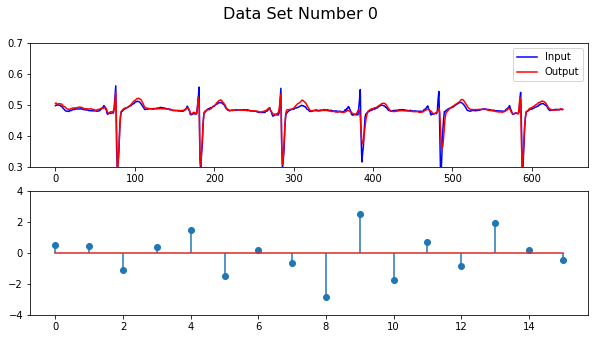

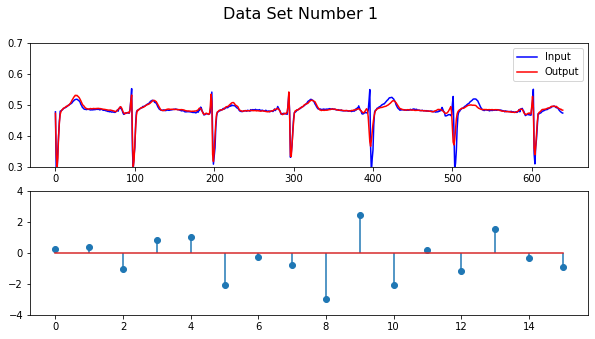

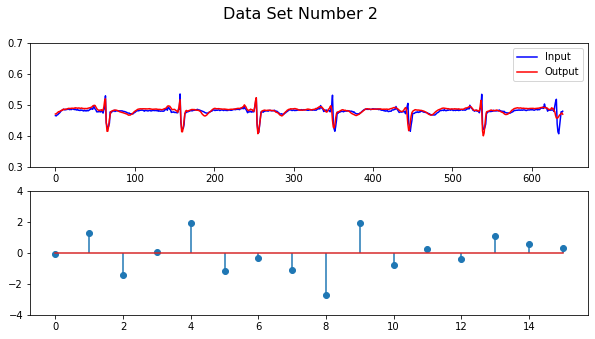

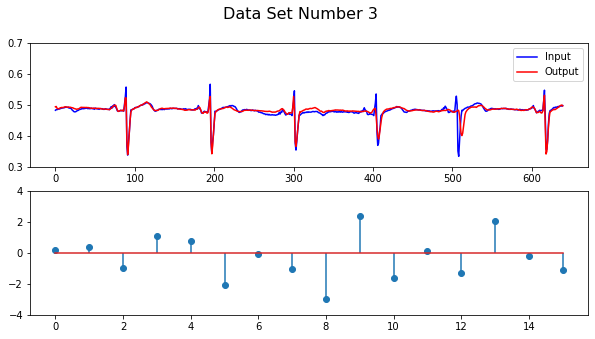

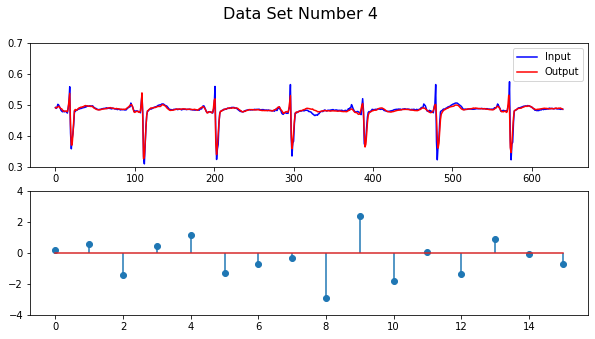

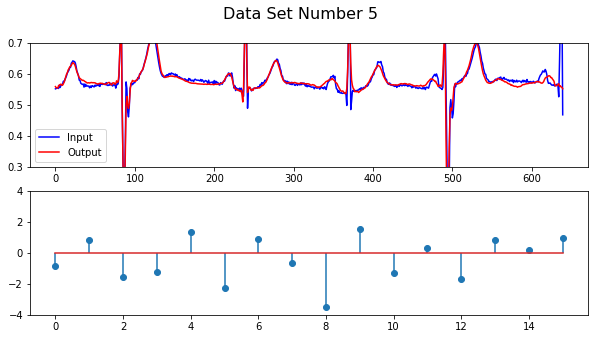

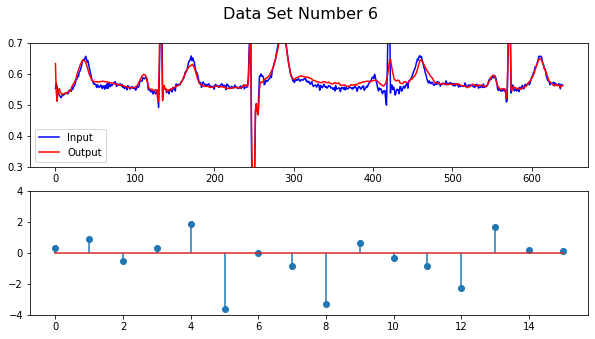

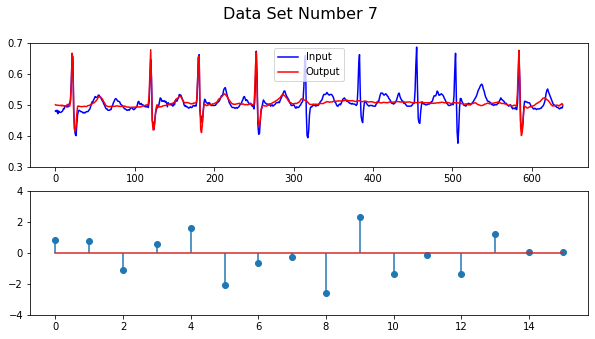

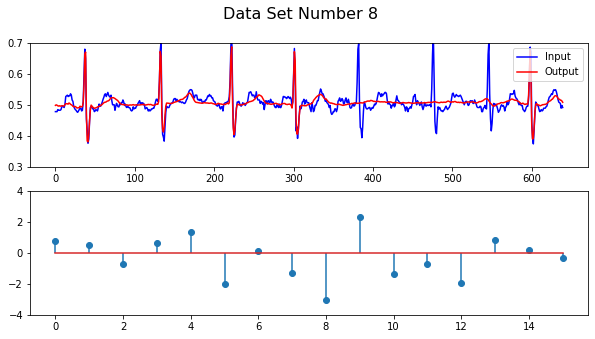

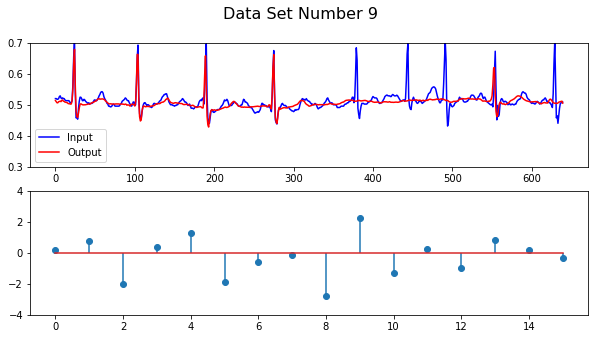

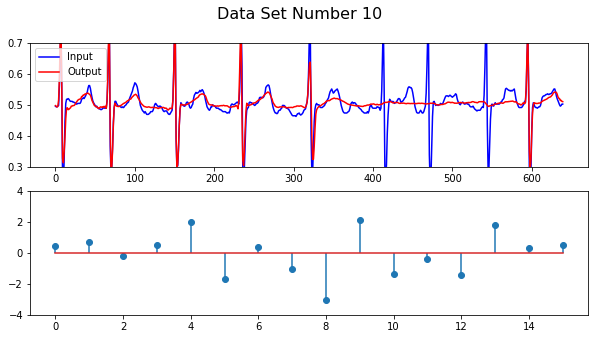

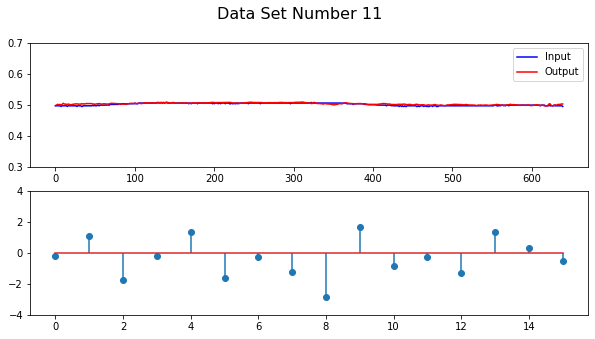

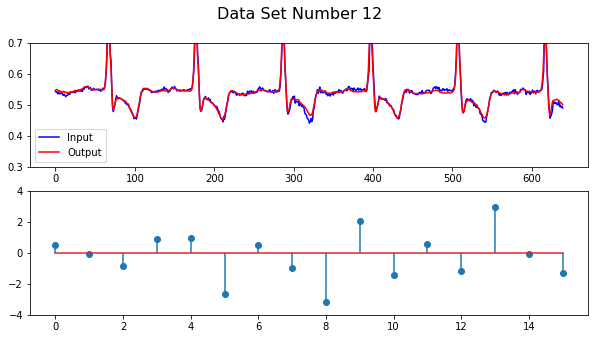

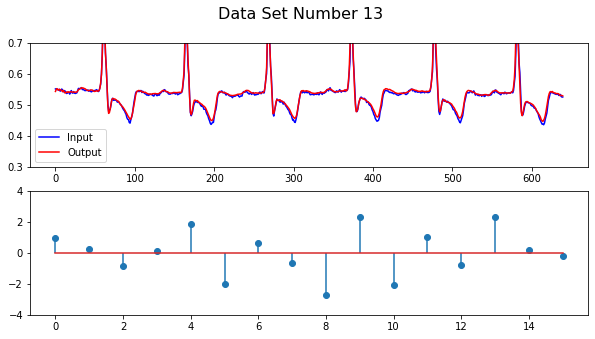

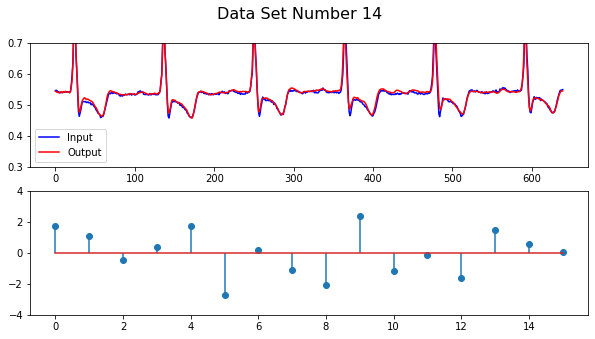

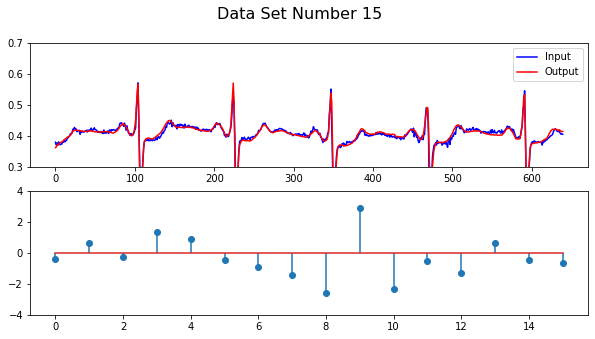

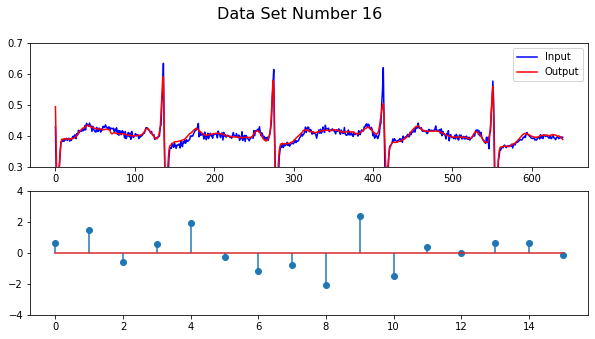

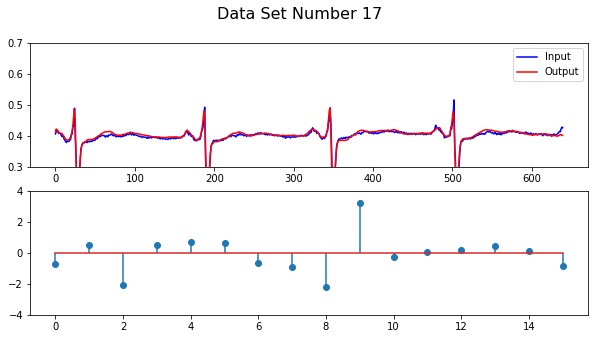

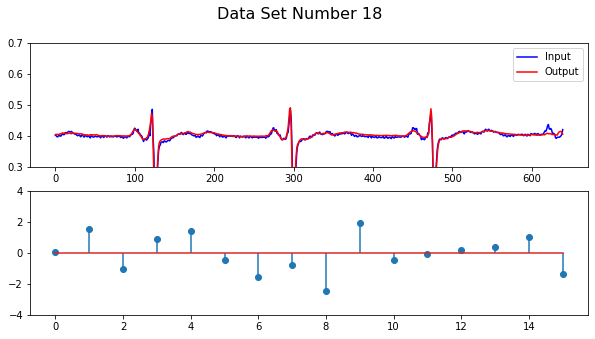

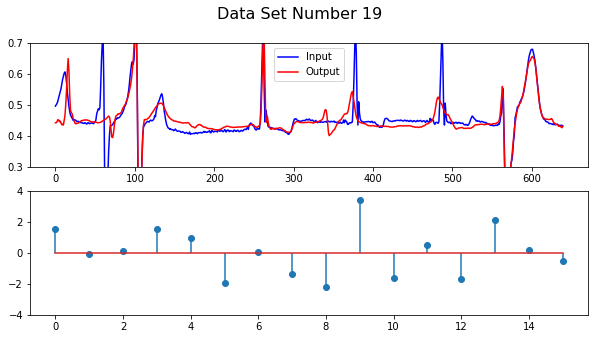

(20, 640, 1)


In [7]:
show_num = 20
show_idx = 0

sample_arr_list = []


for arr in train_set_arr[::10000]:
    sample_arr_list.append(arr)
    tens = tf.convert_to_tensor(arr.reshape(1,640,1), dtype=tf.float32)
    outputs, latents, _ = model(tens)
    
    real = arr.reshape(-1)
    pred = outputs.numpy().reshape(-1)
    late = latents.numpy().reshape(-1)
    
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    ax.plot(np.arange(time_size), real, label="Input", color="b")
    ax.plot(np.arange(time_size), pred, label="Output", color="r")
    ax.set(ylim=(0.3, 0.7))
    ax.legend()
    
    ax2.stem(late)
    ax2.set(ylim=(-4, 4))
    fig.suptitle('Data Set Number {}'.format(show_idx), fontsize=16)
    plt.show()
    show_idx+=1
    if show_idx == show_num:
        break
        
sample_arr = np.array(sample_arr_list)
print(sample_arr.shape)

# 신호 변형 후 입력

In [9]:
origin_sig = sample_arr[0].copy()
trans_sig = sample_arr[0].copy().reshape(-1)
trans_sig[350:450] = origin_sig.mean()
trans_sig[150:250] = origin_sig.mean()
trans_sig[550:] = origin_sig.mean()

trans_sig2 = sample_arr[0].copy().reshape(-1)
trans_sig2[50:150] = origin_sig.mean()
trans_sig2[250:350] = origin_sig.mean()
trans_sig2[450:550] = origin_sig.mean()

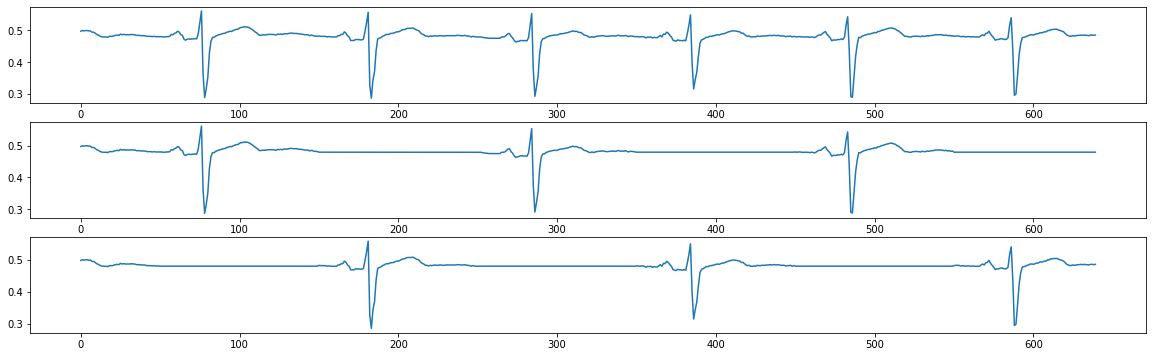

In [10]:
fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
ax1.plot(origin_sig)
ax2.plot(trans_sig)
ax3.plot(trans_sig2)
plt.show()

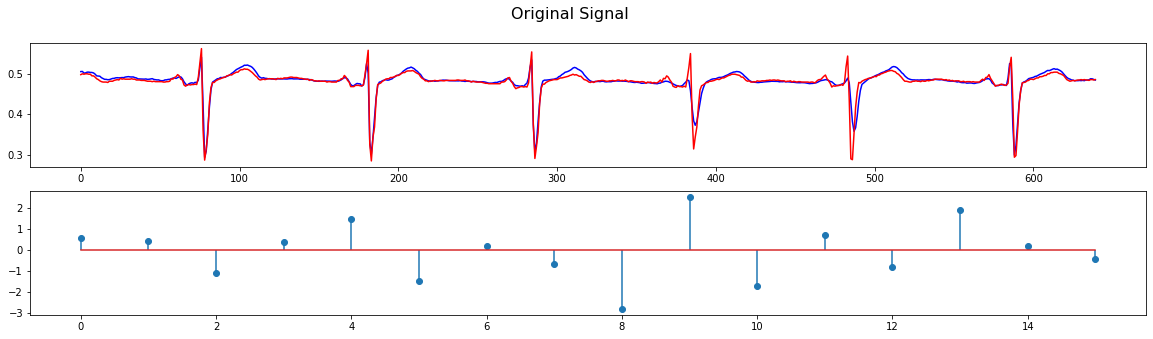

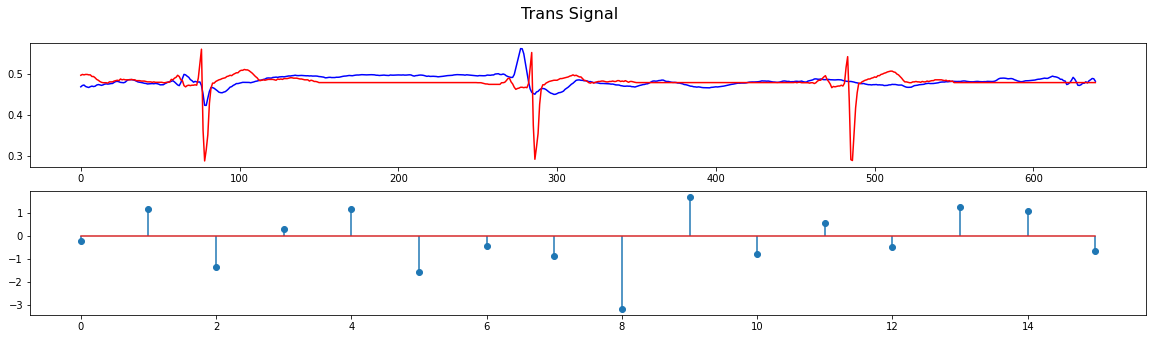

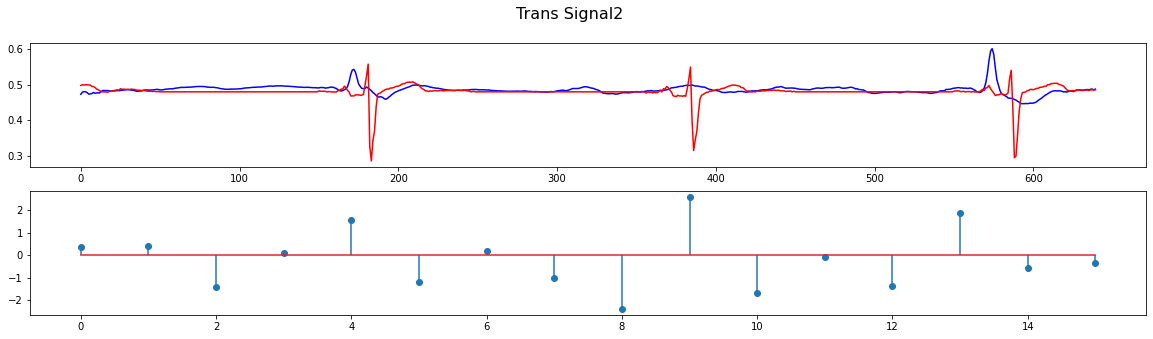

In [11]:
origin_sig_tesnor = tf.convert_to_tensor(origin_sig.reshape(1,640,1), dtype=tf.float32)
trans_sig_tesnor = tf.convert_to_tensor(trans_sig.reshape(1,640,1), dtype=tf.float32)
trans_sig2_tesnor = tf.convert_to_tensor(trans_sig2.reshape(1,640,1), dtype=tf.float32)

origin_sig_outputs, origin_sig_latent, _ = model(origin_sig_tesnor)
trans_sig_outputs, trans_sig_latent, _ = model(trans_sig_tesnor)
trans_sig2_outputs, trans_sig2_latent, _ = model(trans_sig2_tesnor)

fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.plot(origin_sig_outputs.numpy().reshape(-1), color="b")
ax1.plot(origin_sig.reshape(-1), color="r")
ax2.stem(origin_sig_latent.numpy().reshape(-1))
fig.suptitle('Original Signal', fontsize=16)
plt.show()

fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.plot(trans_sig_outputs.numpy().reshape(-1), color="b")
ax1.plot(trans_sig.reshape(-1), color="r")
ax2.stem(trans_sig_latent.numpy().reshape(-1))
fig.suptitle('Trans Signal', fontsize=16)
plt.show()

fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.plot(trans_sig2_outputs.numpy().reshape(-1), color="b")
ax1.plot(trans_sig2.reshape(-1), color="r")
ax2.stem(trans_sig2_latent.numpy().reshape(-1))
fig.suptitle('Trans Signal2', fontsize=16)
plt.show()

# 기준 샘플 추출

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
Decoder_Module (Functional)  (None, 640, 1)            5180097   
Total params: 5,180,097
Trainable params: 5,180,097
Non-trainable params: 0
_________________________________________________________________


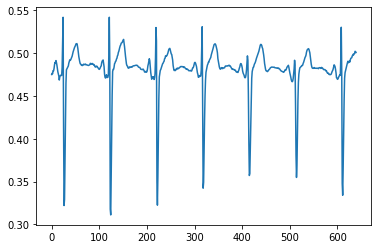

In [14]:
DL_input = tf.keras.Input(model.layers[4].input_shape[1:])
DL_model = DL_input
DL_model = model.layers[4](DL_model)
DL_model = tf.keras.Model(inputs=DL_input, outputs=DL_model)

DL_model.summary()

find_idx = 5
now_idx = 0
for x in train_set_tensor:
    now_idx+=1
    if now_idx == find_idx:
        output, latent_arr, _ = model(x)
        break
        
sample_latent_arr = latent_arr.numpy()[10]
sample_latent_arr = sample_latent_arr.reshape(1,16)

sample_latent_tensor = tf.convert_to_tensor(sample_latent_arr, dtype=tf.float32)

output_sampel = DL_model(sample_latent_tensor)
plt.plot(output_sampel.numpy().reshape(-1))

# Latent Space 조작

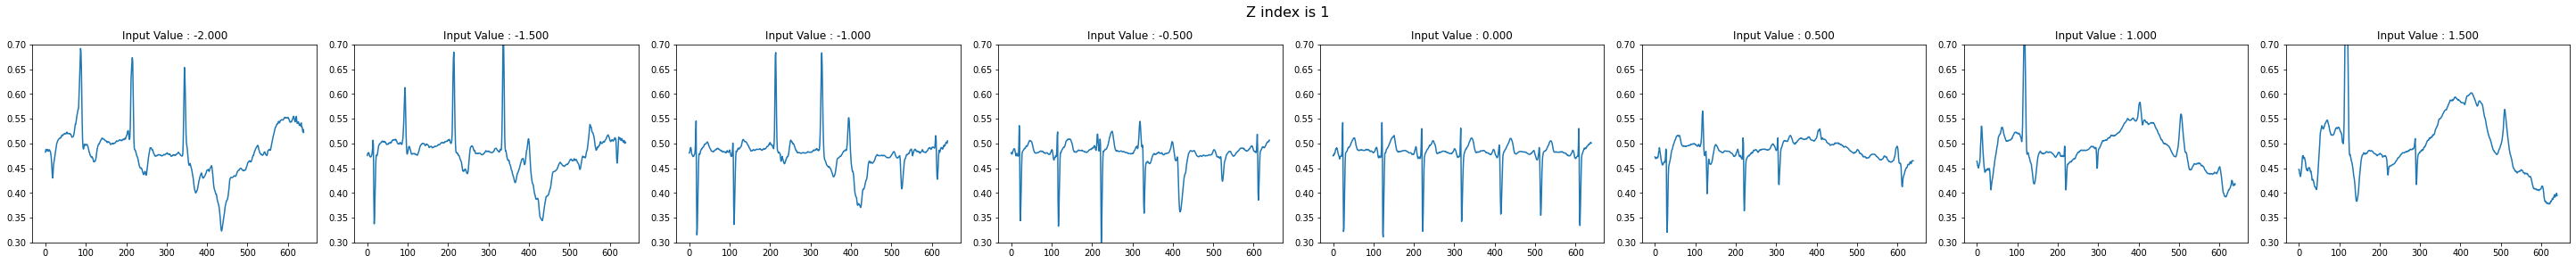

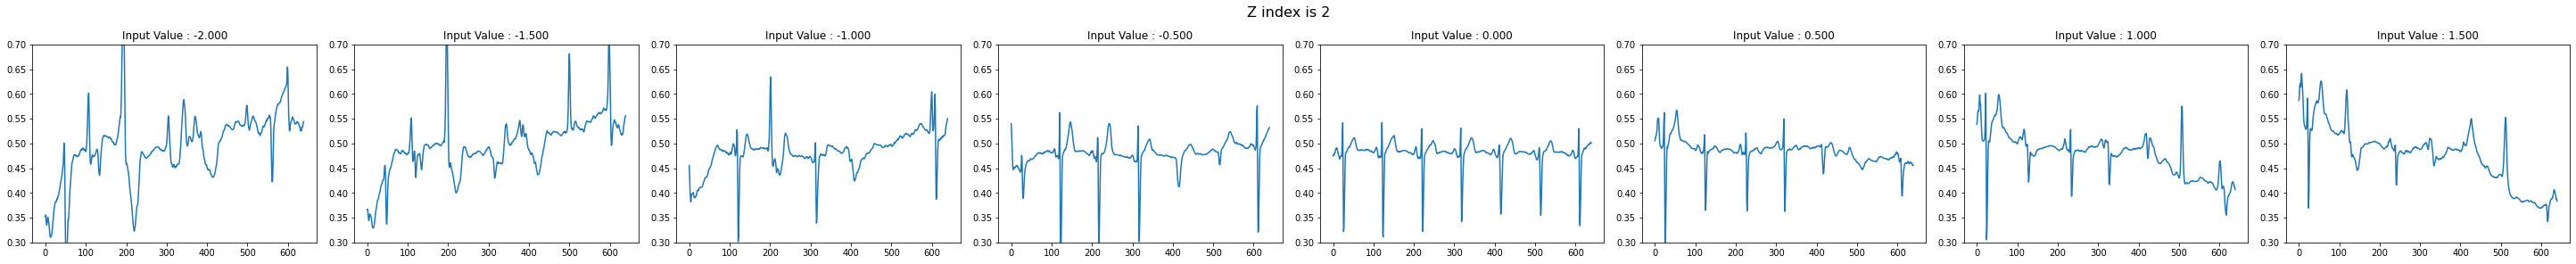

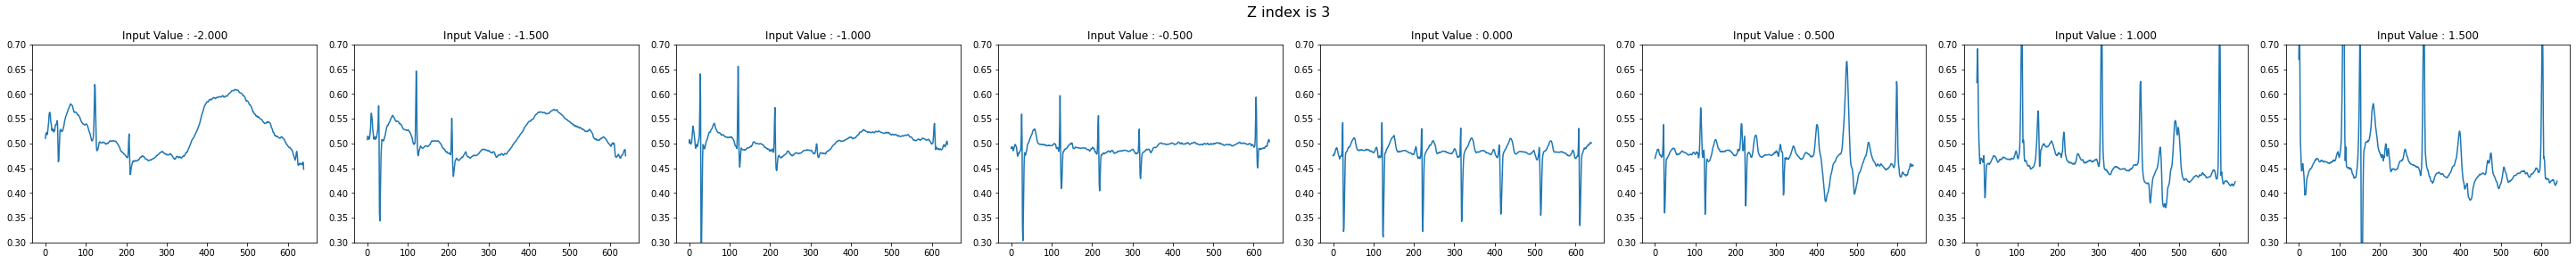

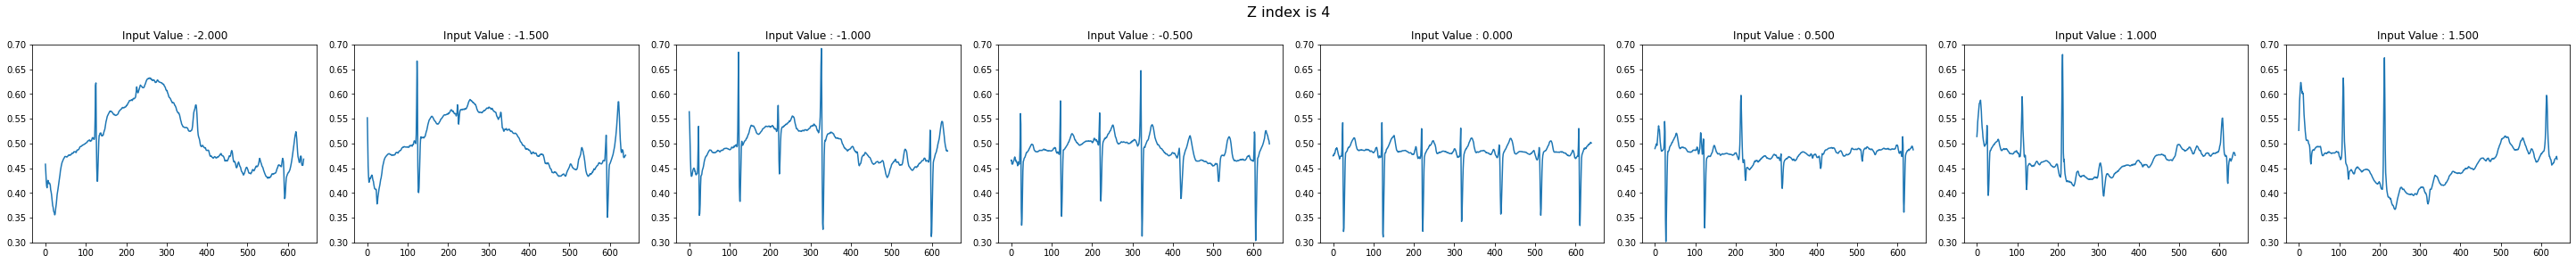

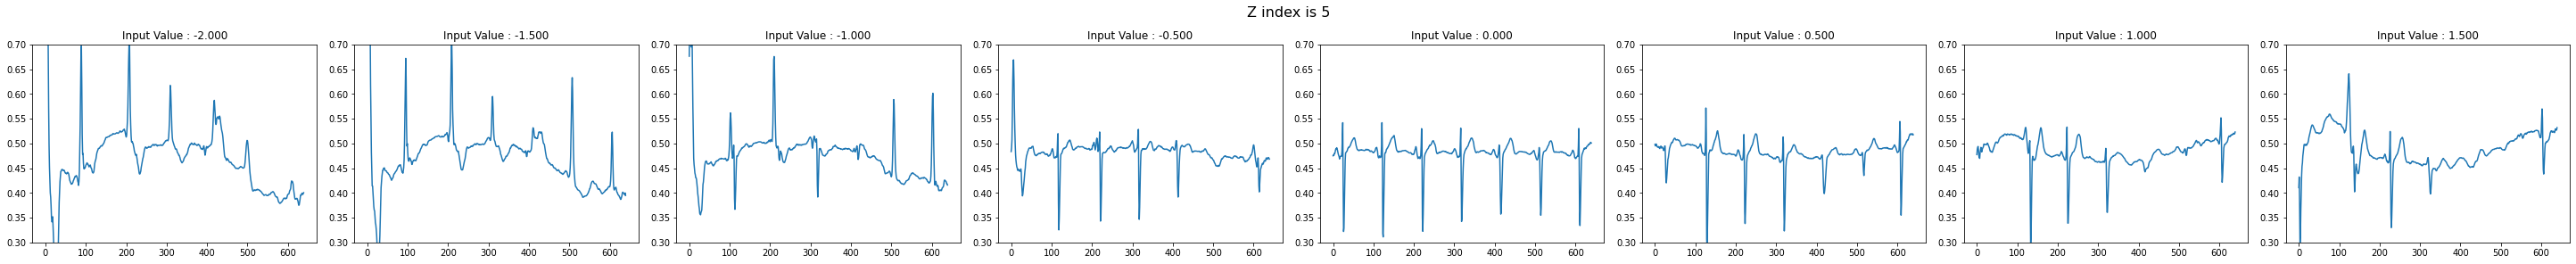

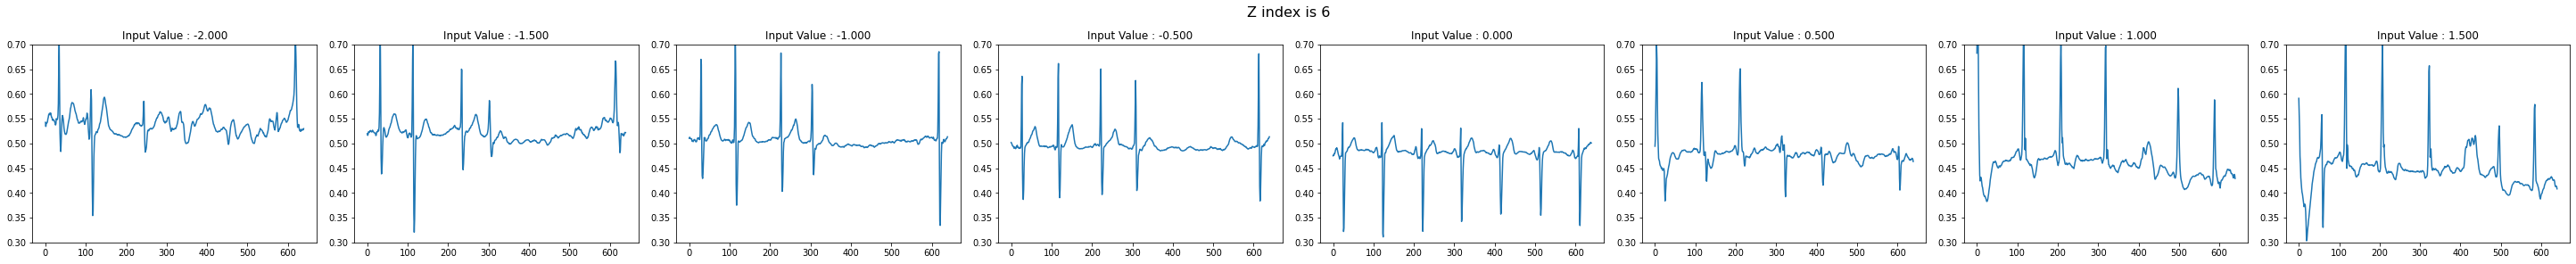

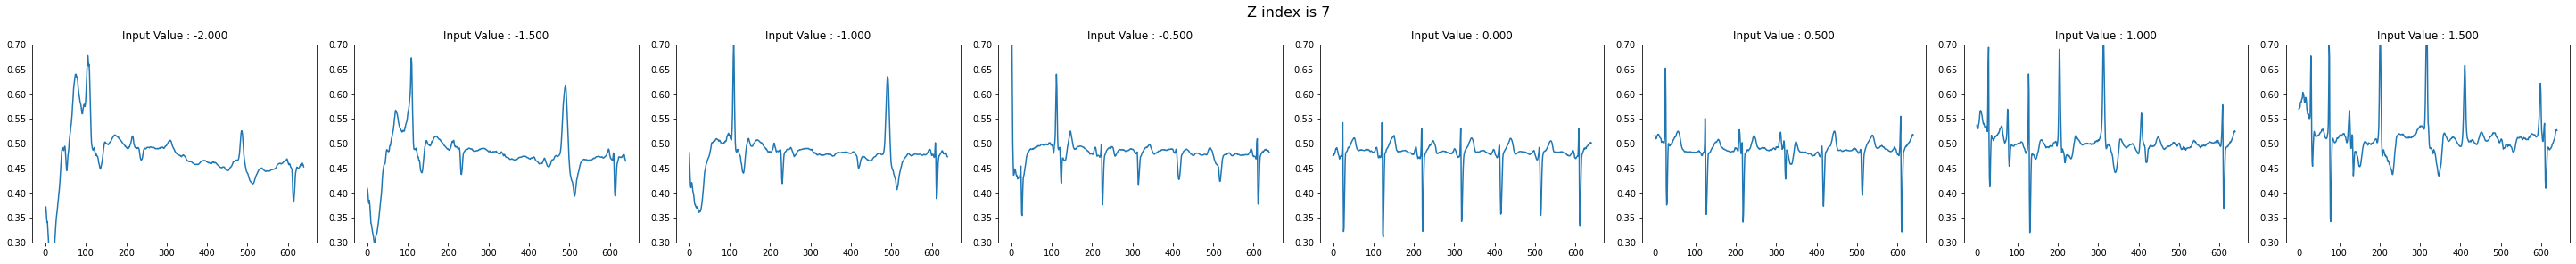

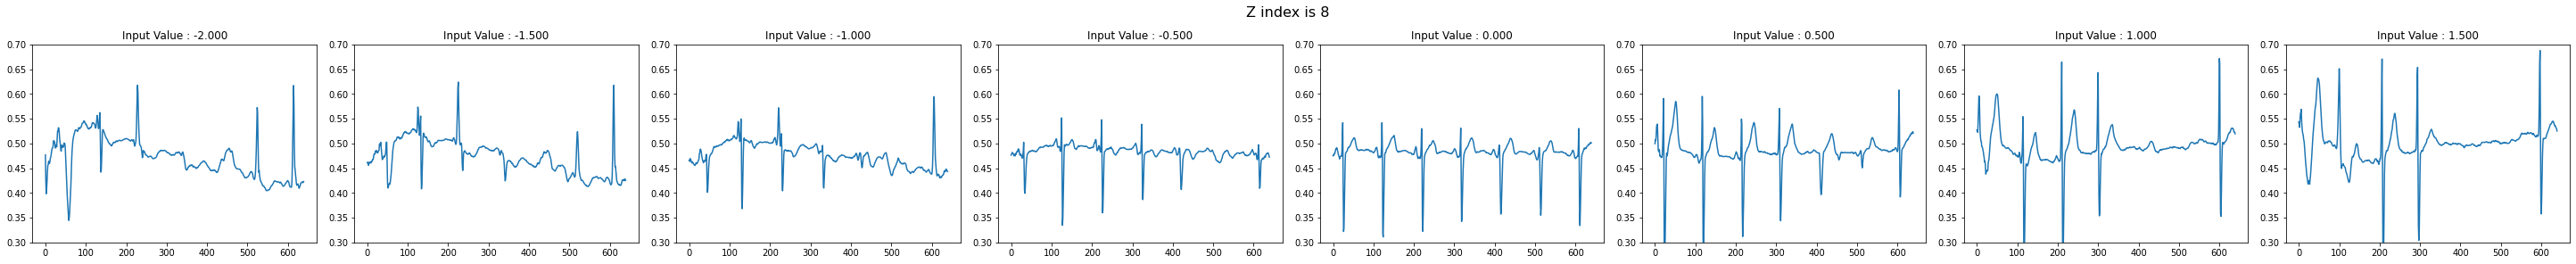

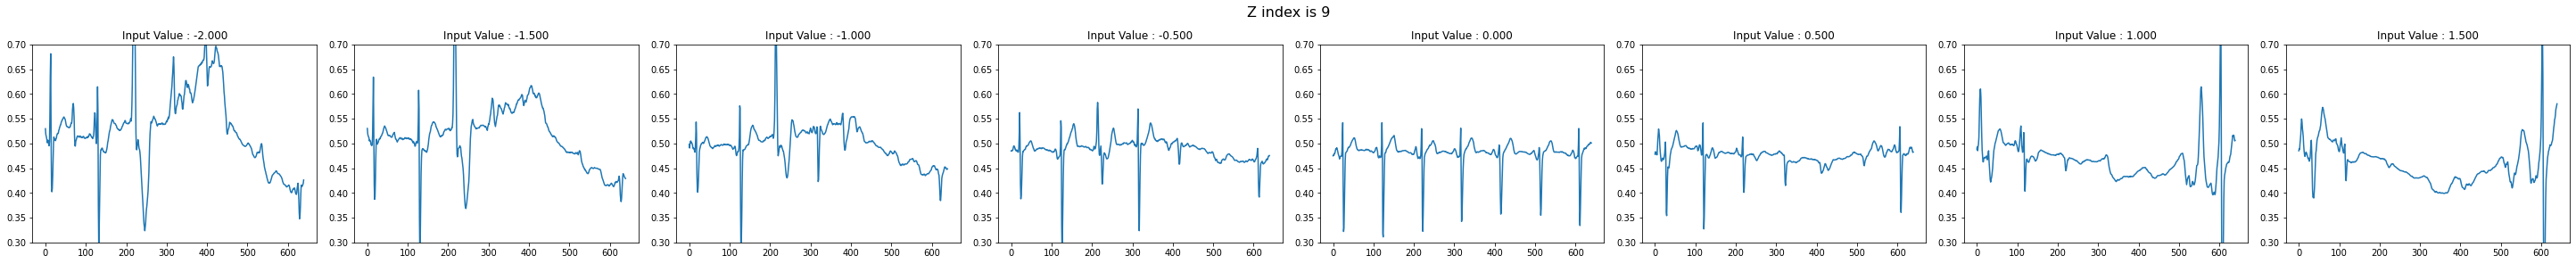

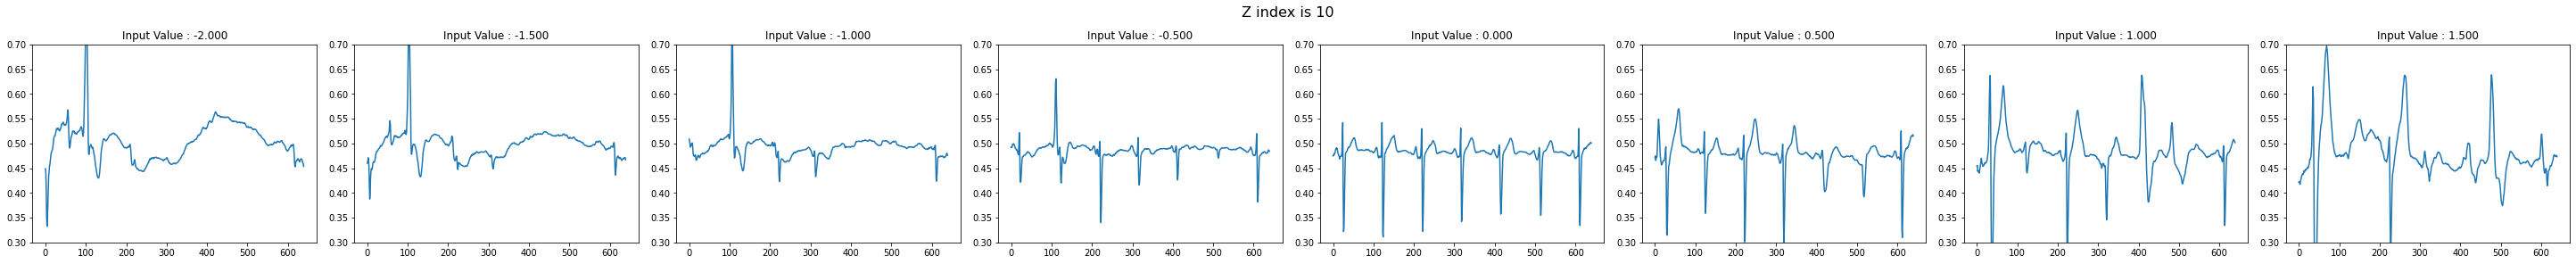

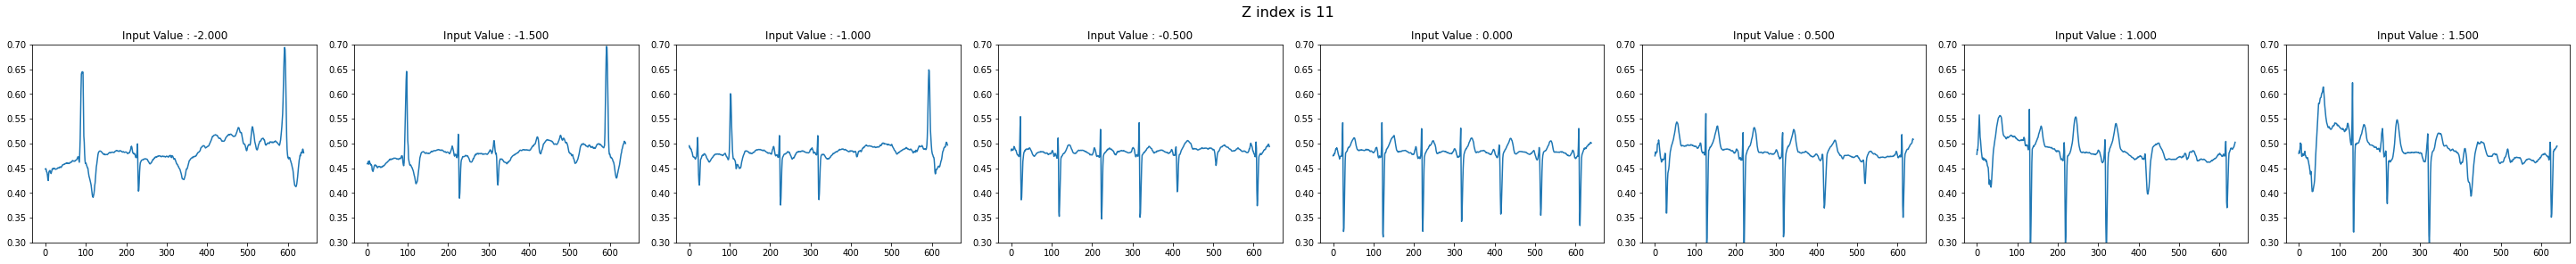

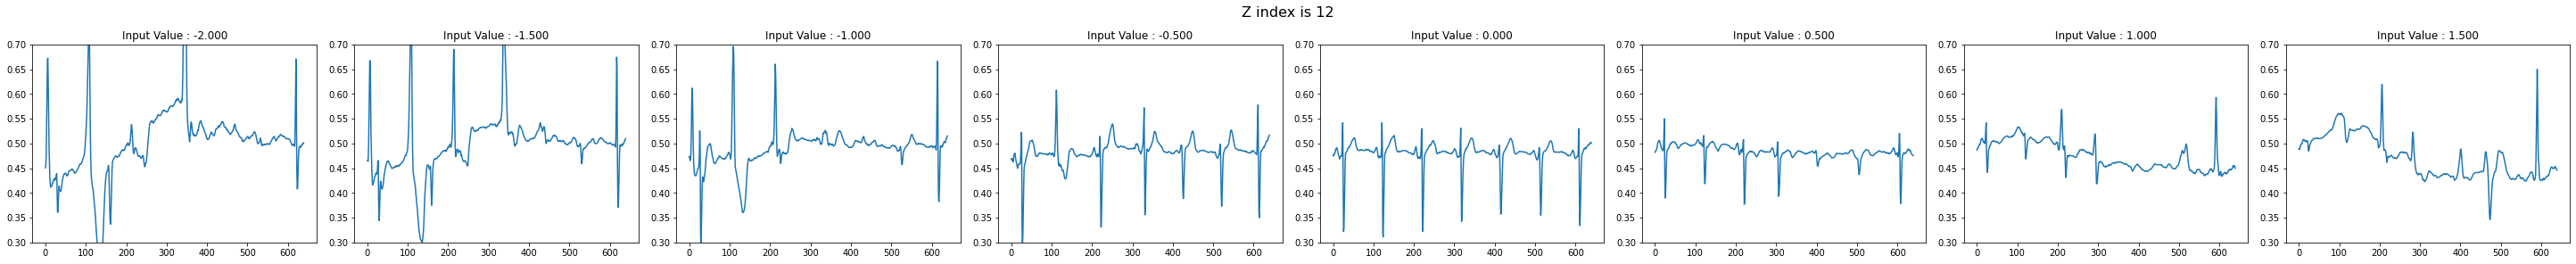

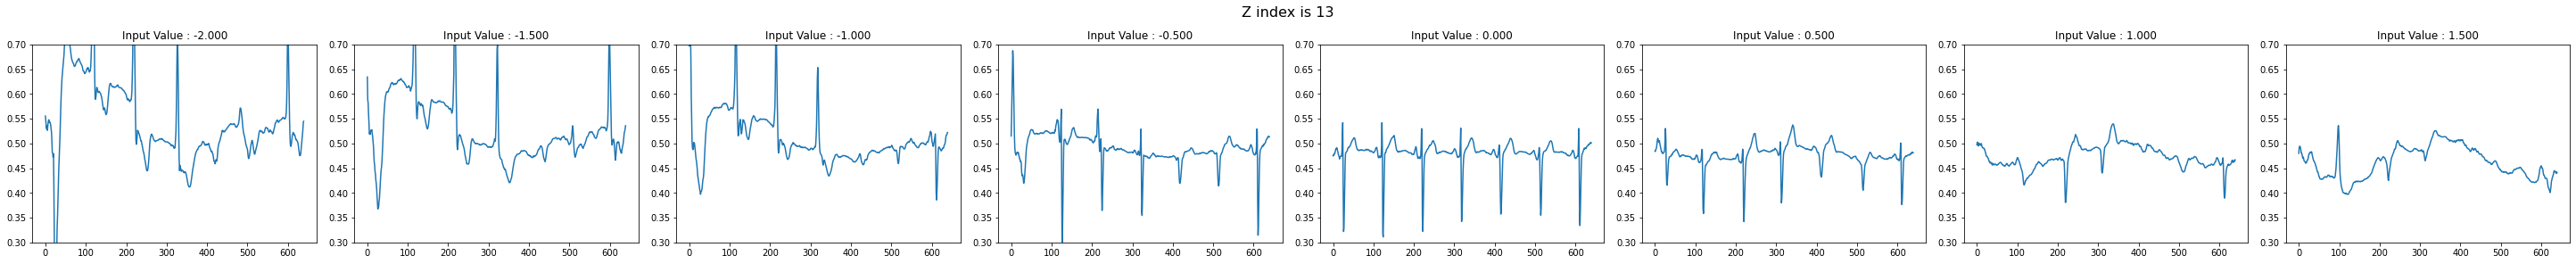

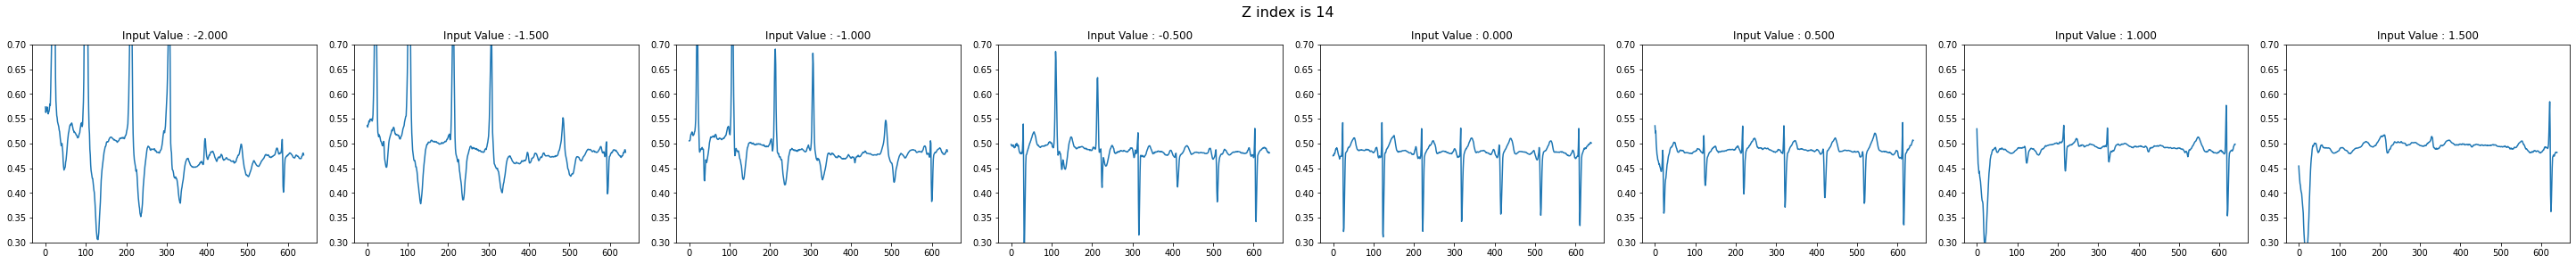

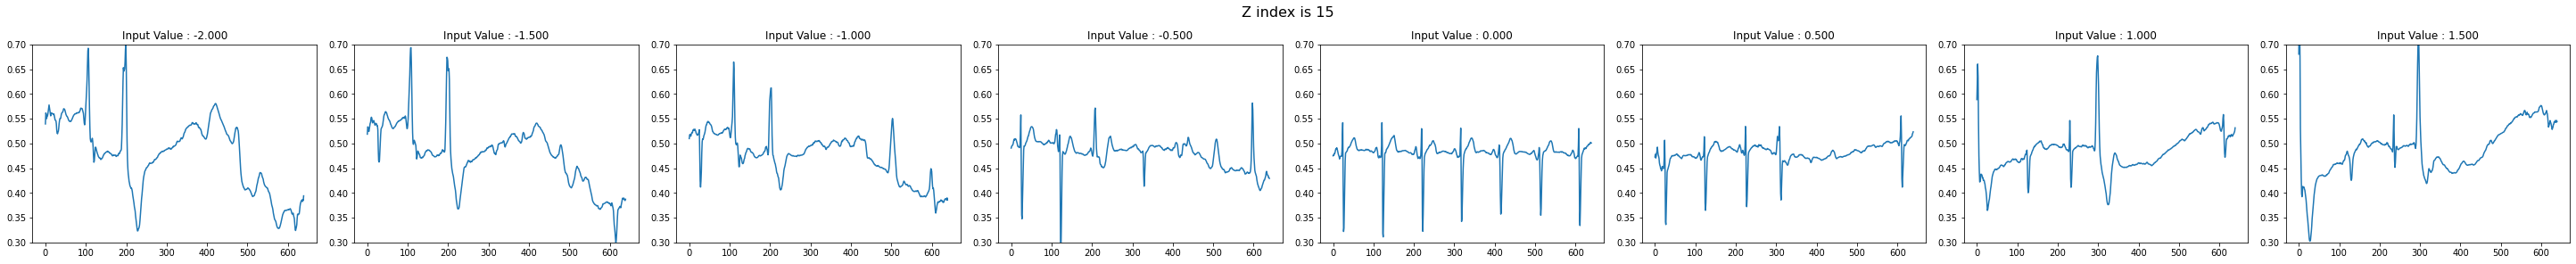

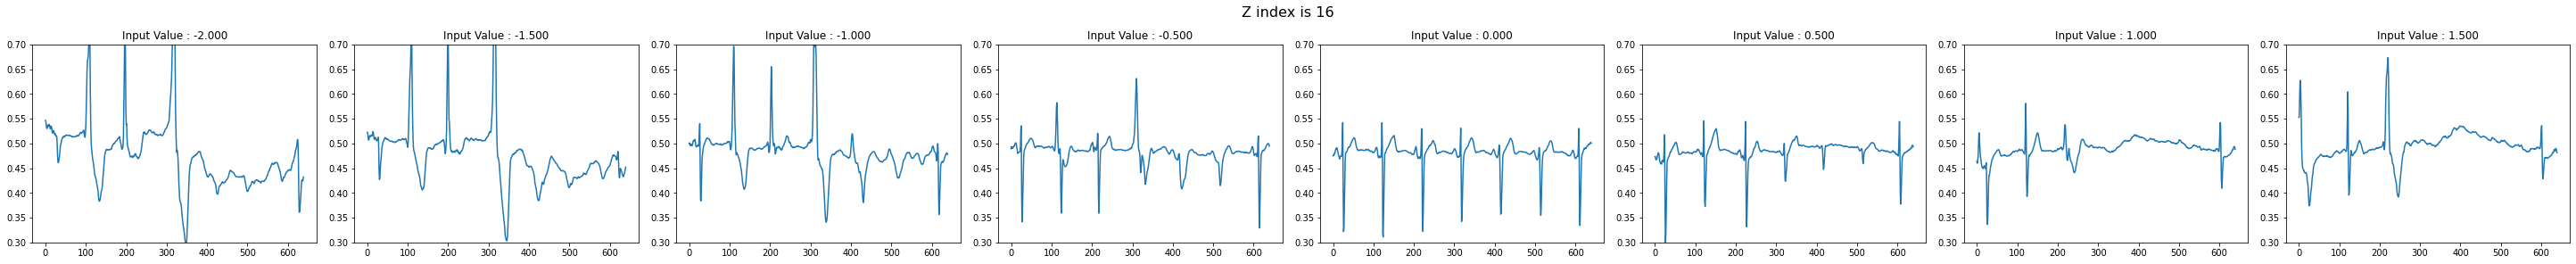

In [15]:
add_arr = np.arange(-2, 2, 0.5)

for z_idx in range(16):
    fig = plt.figure(figsize=(len(add_arr)*5,4), constrained_layout=True)
    axs = fig.subplots(1, len(add_arr))
    for idx, ax in enumerate(axs):
        for_input_mu = sample_latent_arr.copy()
        for_input_mu[:,z_idx] += add_arr[idx]
        outs = DL_model(for_input_mu).numpy().reshape(-1)
        ax.plot(np.arange(len(outs)), outs)
        ax.set_title("Input Value : {:.3f}".format(add_arr[idx]))
        ax.set(ylim=(0.3, 0.7))
    fig.suptitle('Z index is {}'.format(z_idx+1), fontsize=16)
    plt.show()